# 01 - Data Preprocessing

This code in this notebook was run with the following configuration:

    pd.__version__: 0.21.0

In [1]:
import os
import pandas as pd

print(pd.__version__)

0.21.0


In [2]:
!ls ../data/

items.csv                          yelp_academic_dataset_business.csv
reviews.csv                        yelp_academic_dataset_review.csv


## Load Businesses

Load all business information, but only keep those that have been explicitly categorized as "restarants".

In [3]:
path = '../data/yelp_academic_dataset_business.csv'
df_businesses = pd.read_csv(path, low_memory=False).dropna()
df_businesses['is_restaurant'] = df_businesses.categories.apply(lambda c: 'Restaurants' in c)

df_restaurants = df_businesses.query('is_restaurant == True').copy()
df_restaurants.drop('is_restaurant', axis='columns', inplace=True)
display(df_restaurants.head(3))
del df_businesses

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,type
2,979 Bloor Street W,"Alcohol: none,Ambience: {'romantic': False, 'i...",EDqCEAGXVGCH4FJXgqtjqg,"Restaurants,Pizza,Chicken Wings,Italian",Toronto,"Monday 11:0-2:0,Tuesday 11:0-2:0,Wednesday 11:...",1,43.661054,-79.429089,Pizza Pizza,Dufferin Grove,M6H 1L5,7,2.5,ON,business
23,"2000 Mansfield Street, Suite 104",Caters: True,a1Ba6XeIOP48e64YFD0dMw,"Sandwiches,Breakfast & Brunch,Salad,Restaurants",Montréal,"Monday 6:30-17:0,Tuesday 6:30-17:0,Wednesday 6...",1,45.502346,-73.573807,La Prep,Ville-Marie,H3A 2Z6,3,4.0,QC,business
25,"123 Front St, Unit 103 and 103-A","Alcohol: none,Ambience: {'romantic': False, 'i...",826djy6K_9Fp0ptqJ2_Yag,"Fast Food,Mexican,Restaurants",Toronto,"Monday 10:45-22:0,Tuesday 10:45-22:0,Wednesday...",1,43.644920,-79.383333,Chipotle Mexican Grill,Downtown Core,M5J 2M2,68,3.5,ON,business


## Load Reviews

Read all reviews from the CSV file, but only keep those that are associated with the business IDs from the recently created `df_restaurants`. This process takes about 2 minutes to run for this particular dataset.

In [4]:
%%time
df_reviews = pd.read_csv('../data/yelp_academic_dataset_review.csv',low_memory=False).dropna()
print('Loaded {:,} reviews'.format(len(df_reviews)))
business_ids = df_restaurants.business_id.unique().tolist()
df_reviews = df_reviews.query('business_id == @business_ids')
print('Filtered {:,} restaurant reviews'.format(len(df_reviews)))

Loaded 4,153,148 reviews
Filtered 1,253,064 restaurant reviews
CPU times: user 43.8 s, sys: 8.02 s, total: 51.8 s
Wall time: 52.5 s


In [5]:
df_reviews['review_time'] = pd.to_datetime(df_reviews.date)
df_reviews['review_year'] = df_reviews.review_time.dt.year

## Rename and Filter Columns in DataFrames
For consistency, let's define aliases for the original column names from the dataset.

In [6]:
column_map = {
    'business_id': 'item_id', 
    'text': 'review_text', 
    'date': 'review_time',
    'name': 'item_name',
    'stars': 'average_rating'
}

df_reviews.rename(columns=column_map, inplace=True)
df_restaurants.rename(columns=column_map, inplace=True)

# Keep only the columns we need for our recommender.
df_reviews = df_reviews[
    ['user_id', 
     'review_id',
     'review_text',
     'item_id', 
     'average_rating', 
     'review_time', 
     'review_year']
]

## Restaurant Statistics

In [7]:
def print_stats(df_reviews=None):
    print('Restaurant Stats')
    print('~'*32)
    tmpl = '{:<15}: {:>15}'
    print(tmpl.format('Reviews', '{:,}'.format(len(df_reviews))))
    print(tmpl.format('Items', '{:,}'.format(df_reviews.item_id.nunique())))
    print(tmpl.format('Users', '{:,}'.format(df_reviews.user_id.nunique())))

    avg_rating = '{:.2f} (± {:.2f})'.format(
        df_reviews.average_rating.mean(), 
        df_reviews.average_rating.std()
    )

    print(tmpl.format('Avg. Rating', avg_rating))

In [8]:
print_stats(df_reviews)

Restaurant Stats
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reviews        :       1,253,064
Items          :          15,659
Users          :         421,901
Avg. Rating    :   3.74 (± 1.28)


## Sample Reviews
For the purpose of this demo, let's focus only on reviews written in 2014 -- simply because we can 😉

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

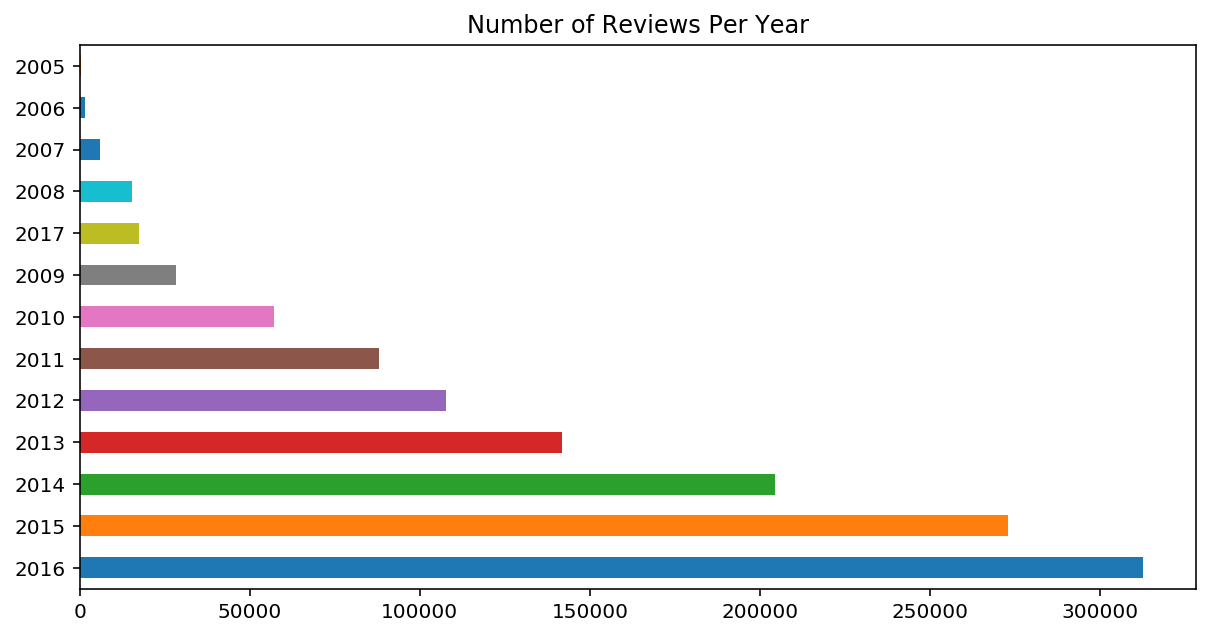

In [10]:
df_reviews.review_year.value_counts().plot(
    kind='barh', 
    rot=0, 
    figsize=(10,5), 
    title='Number of Reviews Per Year'
);

In [11]:
review_years = [2009]
df_reviews = df_reviews[df_reviews.review_year.isin(review_years)]
item_ids = df_reviews.item_id.unique().tolist()

# Remove restaurants that have no reviews due to our aggressive sampling
df_restaurants = df_restaurants.query('item_id == @item_ids')

## Restaurant Statistics, Again

In [12]:
print_stats(df_reviews)

Restaurant Stats
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Reviews        :          28,344
Items          :           4,174
Users          :          11,165
Avg. Rating    :   3.68 (± 1.14)


## Save Sample to Disk

In [13]:
df_restaurants.to_csv(os.path.join('../data/items.csv'), index=False)
df_reviews.to_csv(os.path.join('../data/reviews.csv'), index=False)

## Create User-Item Rating Matrix
Not that we need it, but simplest way to build a recommender system starts with such a rating matrix.

In [14]:
header = True
df_matrix = df_reviews.pivot(index='user_id', columns='item_id', values='average_rating')
df_matrix.fillna(0, inplace=True)  # Replace NaNs with 0s.

print('df_matrix.shape', df_matrix.shape)

df_matrix_ratings = df_matrix.copy()
df_matrix_ratings.to_csv('yp-matrix-ratings.csv', header=header, index=False)
print(df_matrix_ratings.shape)

# Convert ratings matrix to binary matrix
df_matrix_binary = df_matrix.applymap(lambda x: 1 if x > 0 else 0)
df_matrix_binary.to_csv('yp-matrix-binary.csv', header=header, index=False)
print(df_matrix_binary.shape)

df_matrix.shape (11165, 4174)
(11165, 4174)
(11165, 4174)
